In [7]:
#%matplotlib inline
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import timeit
from functions import *

#The class for Randomized Response:
class Randomized_Response:
    def __init__(self, absz, pri_para): # absz: alphabet size, pri_para: privacy parameter
        self.absz = absz #alphabet size k
        self.exp = math.exp(pri_para) #privacy parameter
        self.flip_prob = (self.absz - 1)/(math.exp(pri_para) + self.absz - 1) #flipping probability to maintain local privacy
    
    def encode_string(self, samples):
        n = len(samples)
        # Start by setting private_samples = samples.
        private_samples_rr = np.copy(samples)
        # Determine which samples need to be noised ("flipped").
        flip = np.random.random_sample(n) < self.flip_prob
        flip_samples = samples[flip]
        # Select new samples uniformly at random to replace the original ones.
        rand_samples = np.random.randint(0, self.absz - 1, len(flip_samples))
        # Shift the samples if needed to avoid sampling the orginal samples.
        rand_samples[rand_samples >= flip_samples] += 1
        # Replace the original samples by the randomly selected ones.
        private_samples_rr[flip] = rand_samples
        return private_samples_rr
    
    def decode_string(self, out_samples, normalization = 0):
        #normalization options: 0: clip and normalize(default)
        #                       1: simplex projection
        #                       else: no nomalization
        n = len(out_samples)
        (counts_rr,temp) = np.histogram(out_samples, range(self.absz+1))
        # Estimate the PMF using the count vector.
        p_rr = (counts_rr / float(n)) * ((self.exp  + self.absz - 1) /(self.exp - 1)) - 1.0 / (self.exp - 1)
        #p_rr = decode_counts(counts_rr, epsilon, n, self.absz)
        # Check if truncation and renormalization is required.

        if normalization == 0: 
            p_rr = probability_normalize(p_rr) #clip and normalize
        if normalization == 1:
            p_rr = project_probability_simplex(p_rr) #simplex projection
        return p_rr
    
class RAPPOR:
    def __init__(self, absz, pri_para): # absz: alphabet size, pri_para: privacy parameter
        self.absz = absz #alphabet size k
        self.exp = math.exp(pri_para / 2.0) #privacy parameter
        self.flip_prob = 1/(math.exp(pri_para/2.0) + 1) #flipping probability to maintain local privacy

    def encode_string(self, samples):
        n = len(samples)
        users = range(n)
        # One-hot encode the input integers.
        private_samples_rappor = np.zeros((n, self.absz))
        private_samples_rappor[users, samples] = 1
        # Flip the RAPPOR encoded bits with probability self.flip_prob
        flip = np.random.random_sample((n, self.absz))
        return np.logical_xor(private_samples_rappor, flip < self.flip_prob)


    def encode_string_light(self, samples):
        #return to count vector of rappor responce, which is less memory intensive
        #also return the cumulated time for adding rappor vectors, which should also be considered as decoding time.
        n = len(samples)
        users = range(n)
        time = 0
        counts = np.zeros(self.absz)
        # One-hot encode the input integers.
        for i in range(n):
            private_samples_rappor = np.zeros(self.absz)
            private_samples_rappor[samples[i]] = 1
            # Flip the RAPPOR encoded bits with probability self.flip_prob
            flip = np.random.random_sample(self.absz)
            private_samples_rappor = np.logical_xor(private_samples_rappor, flip < self.flip_prob) 
            start_time = timeit.default_timer() #record adding time
            counts = counts + private_samples_rappor # add rappor responce vector
            time = time + timeit.default_timer() - start_time      
        return counts,time

    def encode_string_compress(self, samples):
        #encode rappor responces into locations of one, which saves communcation budget when eps is large
        n = len(samples)
        out = [0]*n
        # One-hot encode the input integers.
        for i in range(n):
            private_samples_rappor = np.zeros(self.absz)
            private_samples_rappor[samples[i]] = 1
            # Flip the RAPPOR encoded bits with probability self.flip_prob
            flip = np.random.random_sample(self.absz)
            private_samples_rappor = np.logical_xor(private_samples_rappor, flip < self.flip_prob) 
            out[i] = np.where(private_samples_rappor)[0] # get the locations of ones
        out_list = np.concatenate(out)
        return out_list
    
    def decode_counts(self, counts, n, normalization = 0):

        #normalization options: 0: clip and normalize(default)
        #                       1: simplex projection
        #                       else: no nomalization
        # Estimate the PMF using the count vector
        
        p_rappor = (counts / float(n)) * ((self.exp + 1) /(self.exp - 1)) - 1.0 / (self.exp - 1)
        
        if normalization == 0: 
            p_rappor = probability_normalize(p_rappor) #clip and normalize
        if normalization == 1:
            p_rappor = project_probability_simplex(p_rappor) #simplex projection

        return p_rappor

l1 distance:  0.8529080338008995
prob_sum:  1.0000000000000007
l1 distance:  0.528989942919804
prob_sum:  0.9999999999999981


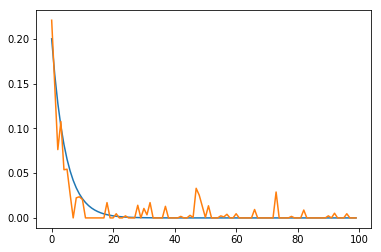

In [13]:
#Testing Script
if __name__ == "__main__":
    k = 100 #absz
    n = 100000
    elements = range(0,k) #ab
    lbd = 0.8 #parameter for geometric dist
    eps = 1 # privacy_para
    prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    #prob = [1/float(k)] * k
    in_list = np.random.choice(elements, n, p=prob) #input symbols
    rr = Randomized_Response(k,eps)
    sample = rr.encode_string(in_list)
    #(outp, temp) = np.histogram(sample,range(k+1))
    #print outp
    prob_est = rr.decode_string(sample) # estimate the original underlying distribution
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))
    prob_est = rr.decode_string(sample,1) # estimate the original underlying distribution
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))

l1 distance:  0.39621377954553494
prob_sum:  0.9999999999999999
l1 distance:  0.22884253195951712
prob_sum:  1.0000000000000009


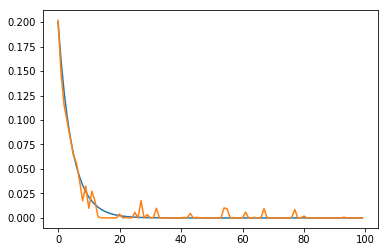

In [14]:
#Testing Script
if __name__ == "__main__":
    #sample = rappor_encoder(in_list, eps, k)
    #outp = np.sum(sample, axis=0)
    rappor = RAPPOR(k,eps)
    out_list = rappor.encode_string_compress(in_list)
    outp,temp = np.histogram(out_list,range(k+1))
    prob_est = rappor.decode_counts(outp,n) # estimate the original underlying distribution
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))
    prob_est = rappor.decode_counts(outp,n,1) # estimate the original underlying distribution
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    #plt.plot(prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est)))